
##### 이 노트북은 CIFAR-10 데이터셋을 사용한 이미지 분류 실험입니다.

In [1]:
# 새로운 셀 (맨 위)
%load_ext autoreload
%autoreload 2

print("✅ Auto-reload 활성화 - 파일 변경 자동 감지")

✅ Auto-reload 활성화 - 파일 변경 자동 감지


In [2]:
# ============================================================
# 1. Python path 설정, 라이브러리 임포트
# ============================================================
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm

%matplotlib inline

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root 생성 및 라이브러리 임포트 완료")

Project root 생성 및 라이브러리 임포트 완료


In [3]:
# ============================================================
# 2. Config 설정
# ============================================================
from src.config import QuickTestConfig,CIFAR10Config,DocumentConfig

# 빠른 테스트
config = QuickTestConfig()
config.print_config()

# ============================================================
# Config 선택 (원하는 것만 주석 해제)
# ============================================================

# 방법 1: 빠른 테스트 (10% 데이터, 1 epoch, 2 fold)
#config = QuickTestConfig()

# 방법 2: CIFAR-10 전체 학습 (전체 데이터, 50 epochs, 5 fold)
# config = CIFAR10Config()

# 방법 3: 문서 분류 대회 (나중에 사용)
# config = DocumentConfig()

# ============================================================
# Config 출력
# ============================================================
config.print_config()

# ============================================================
# 세부 설정 수정 (필요시)
# ============================================================
# 일부 파라미터만 바꾸고 싶을 때 update() 사용

# 예시 1: Epoch와 Batch Size만 수정
# config.update(
#     EPOCHS=10,
#     BATCH_SIZE=128
# )

# 예시 2: 서브셋 비율 변경 (20%만 사용)
# config.update(
#     USE_SUBSET=True,
#     SUBSET_RATIO=0.2
# )

# 예시 3: 모델 변경
# config.update(
#     MODEL_NAME='resnet50',
#     IMAGE_SIZE=224
# )

# 예시 4: 학습률과 Early Stopping 조정
# config.update(
#     LR=0.0001,
#     PATIENCE=10
# )

# 예시 5: K-Fold 수 변경
# config.update(
#     N_FOLDS=5
# )

# 예시 6: 여러 개 한번에 수정
# config.update(
#     MODEL_NAME='efficientnet_b0',
#     BATCH_SIZE=64,
#     EPOCHS=20,
#     LR=0.001,
#     N_FOLDS=3,
#     USE_SUBSET=True,
#     SUBSET_RATIO=0.15
# )

# ============================================================
# 또는 직접 속성 수정도 가능
# ============================================================
# config.EPOCHS = 10
# config.BATCH_SIZE = 64
# config.print_config()  # 변경사항 확인

⚙️  실험 설정 (Hyperparameters)

📦 데이터셋 설정:
  - 데이터셋:          cifar10
  - 이미지 크기:       224x224
  - 서브셋 사용:       Yes
  - 서브셋 비율:       10.0%

🎨 Augmentation 설정:
  - 전략:              auto

🤖 모델 설정:
  - 모델:              efficientnet_b0
  - 클래스 수:         10

🎯 학습 설정:
  - Batch Size:        64
  - Epochs:            1
  - Learning Rate:     0.001
  - K-Fold:            2
  - Early Stop:        5 epochs

🖥️  디바이스:
  - Device:            mps
⚙️  실험 설정 (Hyperparameters)

📦 데이터셋 설정:
  - 데이터셋:          cifar10
  - 이미지 크기:       224x224
  - 서브셋 사용:       Yes
  - 서브셋 비율:       10.0%

🎨 Augmentation 설정:
  - 전략:              auto

🤖 모델 설정:
  - 모델:              efficientnet_b0
  - 클래스 수:         10

🎯 학습 설정:
  - Batch Size:        64
  - Epochs:            1
  - Learning Rate:     0.001
  - K-Fold:            2
  - Early Stop:        5 epochs

🖥️  디바이스:
  - Device:            mps


In [4]:
# ============================================================
# 3. 데이터 로드
# ============================================================
from src.data import load_data, get_train_augmentation, get_val_augmentation

# Config 기반으로 데이터 로드
train_dataset_raw, test_dataset, train_labels, class_names, num_classes = load_data(config)

device = config.DEVICE

print(f"\n✅ 데이터 로드 완료")
print(f"Device: {device}")
print(f"Train: {len(train_dataset_raw):,}, Test: {len(test_dataset):,}")
print(f"Classes ({num_classes}): {class_names}")


🎯 Dataset Type: cifar10
📦 Loading CIFAR10 Data

✅ CIFAR10 Full Data Loaded!
Train: 50,000 images
Test:  10,000 images
Classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

🔥 Subset mode: Using 10% of data
✅ Subset train size: 5,000
✅ Subset test size: 1,000

✅ 데이터 로드 완료
Device: mps
Train: 5,000, Test: 1,000
Classes (10): ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


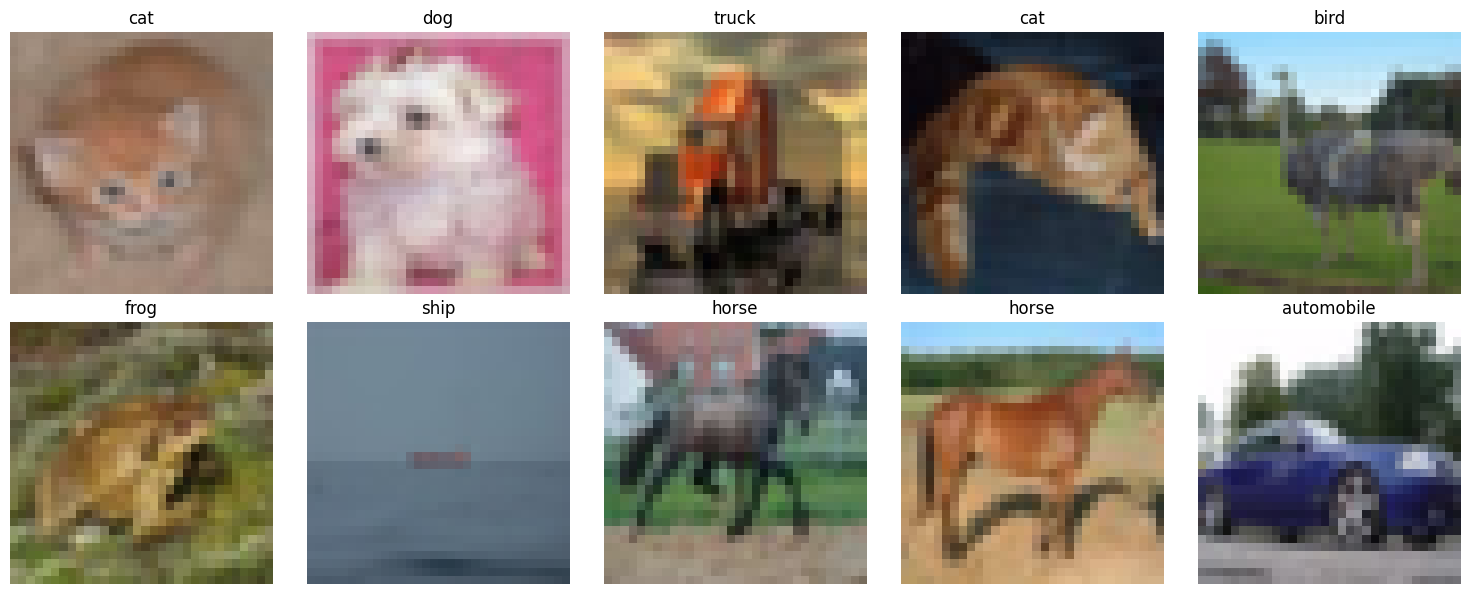

In [5]:
# ============================================================
# 4. 샘플 이미지 시각화 (랜덤)
# ============================================================
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# 랜덤 인덱스 생성
random_indices = random.sample(range(len(train_dataset_raw)), 10)

for i, ax in enumerate(axes.flat):
    image, label = train_dataset_raw[random_indices[i]]
    ax.imshow(image)
    ax.set_title(f"{class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# ============================================================
# 5. 모델 생성
# ============================================================
from src.model import get_model, print_model_info, print_model_list, get_optimizer

# 모델 리스트 보기 (선택 사항)
# print_model_list(config.MODEL_NAME)

# 모델 생성
model = get_model(
    model_name=config.MODEL_NAME,
    num_classes=num_classes,
    pretrained=True
)
model = model.to(device)

# 모델 정보 출력
print_model_info(model, device, config.MODEL_NAME)

# Optimizer
optimizer = get_optimizer(model, config)
criterion = nn.CrossEntropyLoss()

print(f"\n✅ 학습 준비 완료")
print(f"Optimizer: Adam (lr={config.LR})")
print(f"Loss: CrossEntropyLoss")

✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용

📊 모델 정보
  모델 이름:           EfficientNet-B0
  전체 파라미터:       4,020,358
  학습 가능 파라미터:  4,020,358
  고정 파라미터:       0
  디바이스:            mps

✅ 학습 준비 완료
Optimizer: Adam (lr=0.001)
Loss: CrossEntropyLoss


In [7]:
# ============================================================
# 6. Wandb 초기화
# ============================================================

if config.USE_WANDB:
    import wandb
    from src.model import MODEL_CONFIGS
    
    # Wandb 로그인 (최초 1회만, 주석 해제)
    # wandb.login()
    
    # 모델 display name
    model_display = MODEL_CONFIGS.get(
        config.MODEL_NAME, 
        {'display_name': config.MODEL_NAME}
    )['display_name']
    
    # 실험 이름
    run_name = f"{config.MODEL_NAME}_bs{config.BATCH_SIZE}_ep{config.EPOCHS}"
    if config.USE_SUBSET:
        run_name += f"_sub{int(config.SUBSET_RATIO*100)}"
    
    # Wandb 초기화
    wandb.init(
        project=config.WANDB_PROJECT,
        name=run_name,
        config=config.to_dict()  # Config 전체를 dict로 변환
    )
    
    print(f"✅ Wandb 초기화: {wandb.run.name}")
    print(f"📊 Project: {config.WANDB_PROJECT}")
else:
    print("⏭️  Wandb 비활성화")
    wandb = None  # 나중에 wandb 체크할 때 사용

⏭️  Wandb 비활성화


In [8]:
# ============================================================
# 7. K-Fold 학습
# ============================================================
from src.train import run_kfold_training

# Config 기반으로 K-Fold 학습 실행
fold_results = run_kfold_training(
    train_dataset_raw=train_dataset_raw,
    train_labels=train_labels,
    num_classes=num_classes,
    config=config,  # ← config 객체 전달
    device=device,
    use_wandb=config.USE_WANDB  # ← config에서 가져오기
)

print("\n" + "="*60)
print("🎉 K-Fold 학습 완료!")
print("="*60)

🚀 K-Fold Cross Validation 시작
Model: efficientnet_b0, Epochs: 1, Batch: 64, Folds: 2
📌 Auto mode: cifar10 → albumentations augmentation

📁 Fold 1/2
Train: 2,500, Val: 2,500


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용

📍 Epoch [1/1]


Train - Loss: 1.7431 | Acc: 50.72% | F1: 0.5068
Val   - Loss: 1.3655 | Acc: 73.56% | F1: 0.7332
✅ Validation F1 improved (0.7332 → 0.7332)

✅ Fold 1 완료! Best Val F1: 0.7332

📁 Fold 2/2
Train: 2,500, Val: 2,500


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용

📍 Epoch [1/1]


Train - Loss: 1.6411 | Acc: 54.96% | F1: 0.5493
Val   - Loss: 0.9257 | Acc: 79.00% | F1: 0.7899
✅ Validation F1 improved (0.7899 → 0.7899)

✅ Fold 2 완료! Best Val F1: 0.7899

📊 K-Fold 결과 요약
Fold 1: Best Val F1 = 0.7332
Fold 2: Best Val F1 = 0.7899
📈 평균 Validation F1: 0.7616 ± 0.0283

🎉 K-Fold 학습 완료!


🚀 전체 평가 프로세스 시작
🔮 앙상블 예측 시작...
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)



🎯 Test Set 최종 결과 (앙상블)
Test Accuracy: 81.30%
Test Macro F1 Score: 0.8124

📈 학습 곡선 시각화...


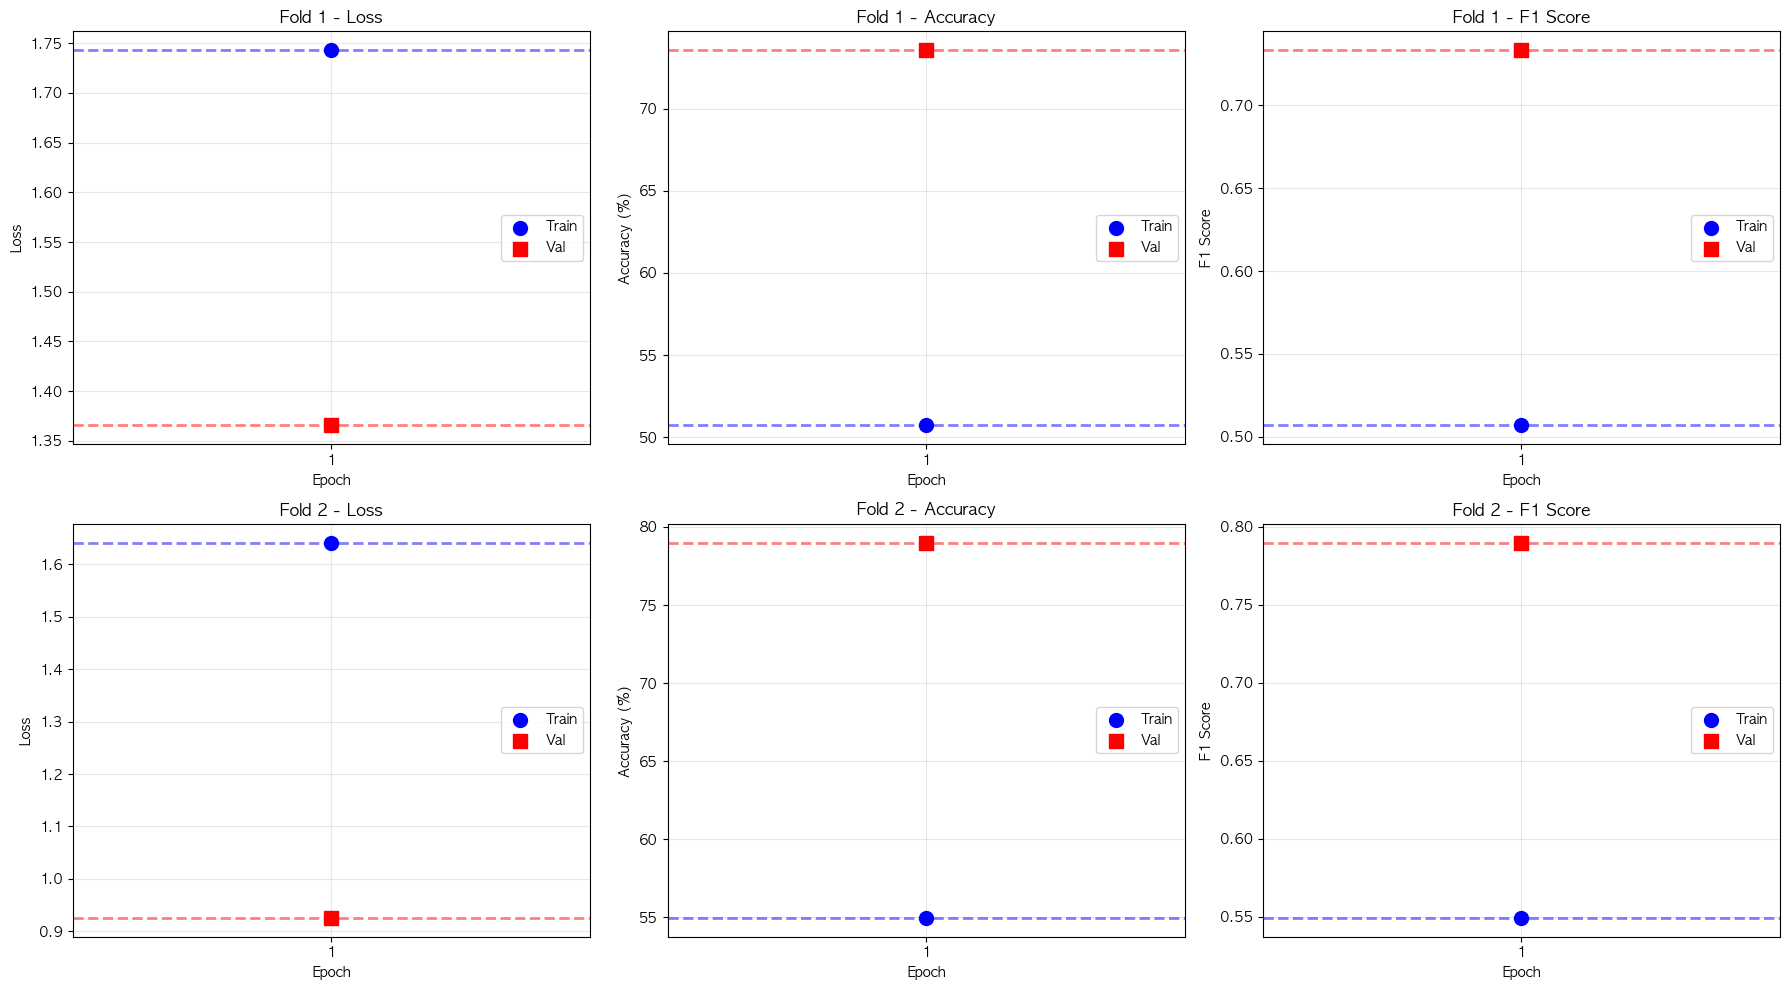

✅ 학습 곡선 시각화 완료!

📊 Confusion Matrix 생성...


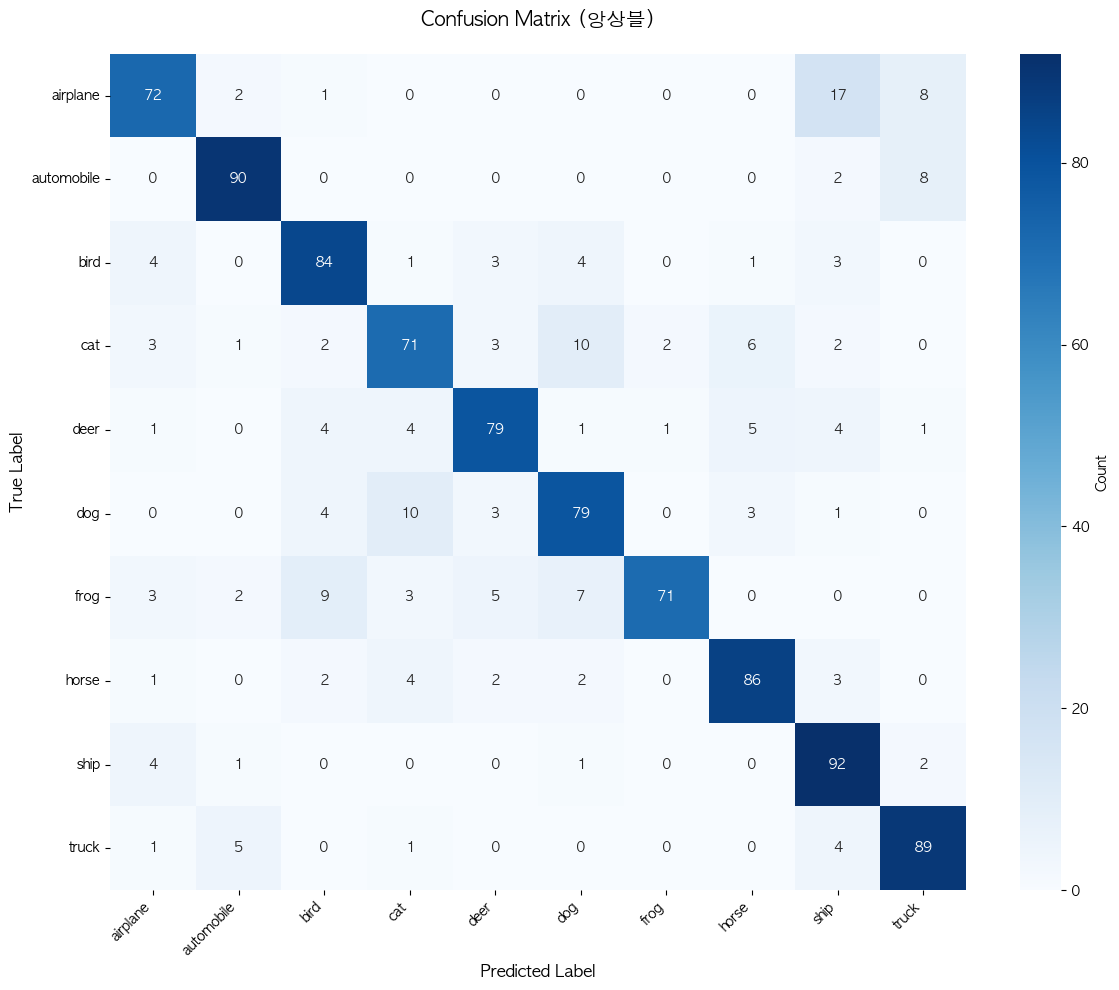


📊 클래스별 정확도
airplane            : 72.00% (72/100)
automobile          : 90.00% (90/100)
bird                : 84.00% (84/100)
cat                 : 71.00% (71/100)
deer                : 79.00% (79/100)
dog                 : 79.00% (79/100)
frog                : 71.00% (71/100)
horse               : 86.00% (86/100)
ship                : 92.00% (92/100)
truck               : 89.00% (89/100)

🔍 오분류 분석...

🎯 Dataset Type: cifar10
📦 Loading CIFAR10 Data

✅ CIFAR10 Full Data Loaded!
Train: 50,000 images
Test:  10,000 images
Classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

🔥 Subset mode: Using 10% of data
✅ Subset train size: 5,000
✅ Subset test size: 1,000

📊 오분류 분석 결과
전체 테스트 샘플: 1,000개
정확히 예측: 813개 (81.30%)
오분류: 187개 (18.70%)

📈 가장 많이 틀린 클래스 조합 (Top 10):
----------------------------------------------------------------------
airplane             → ship                :  17회
dog                  → cat                 :  10회
c

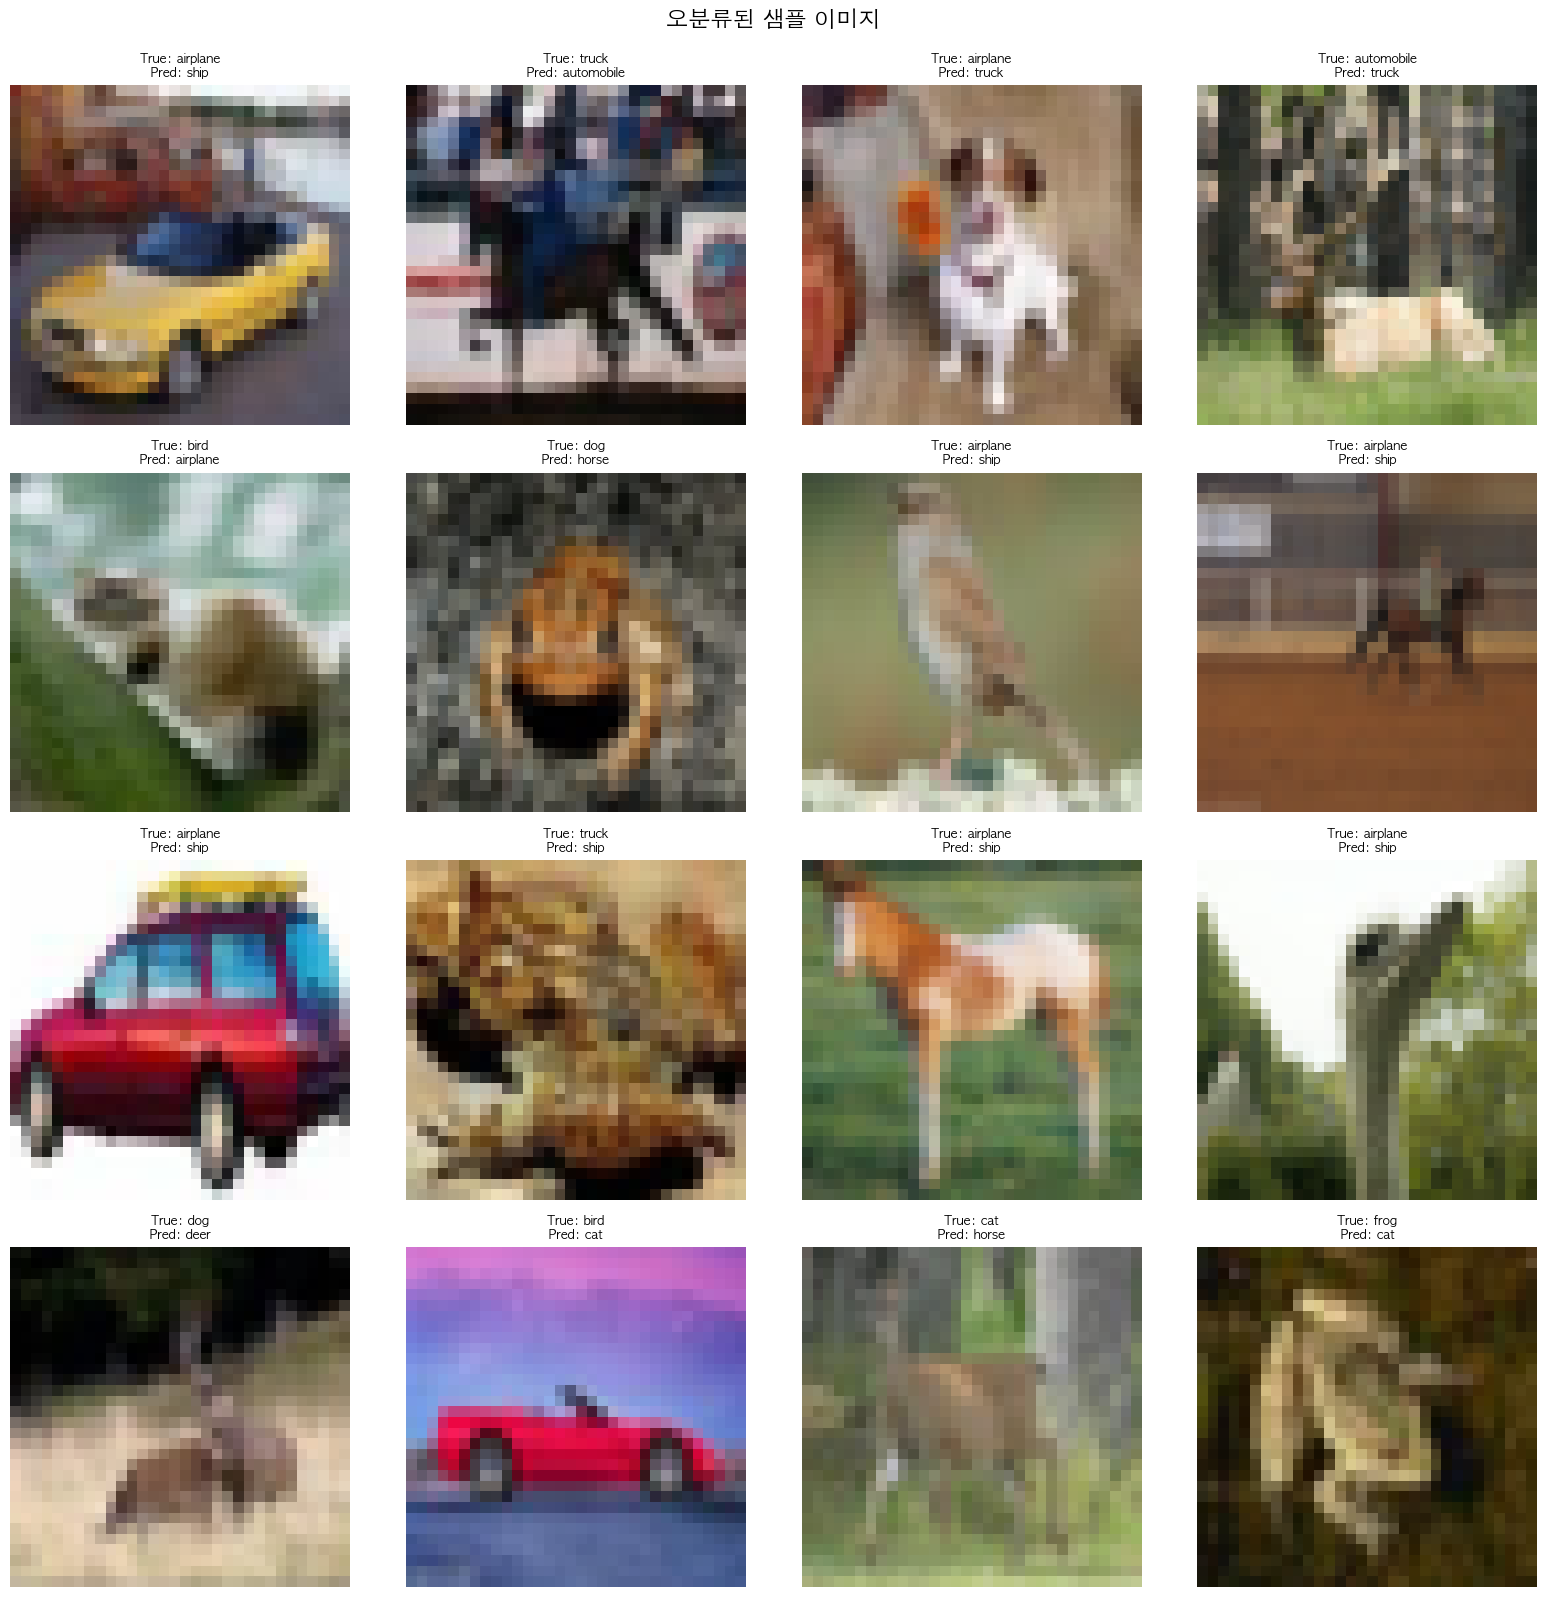


✅ 16개 오분류 샘플 시각화 완료!

📊 클래스별 오분류 비율 시각화...


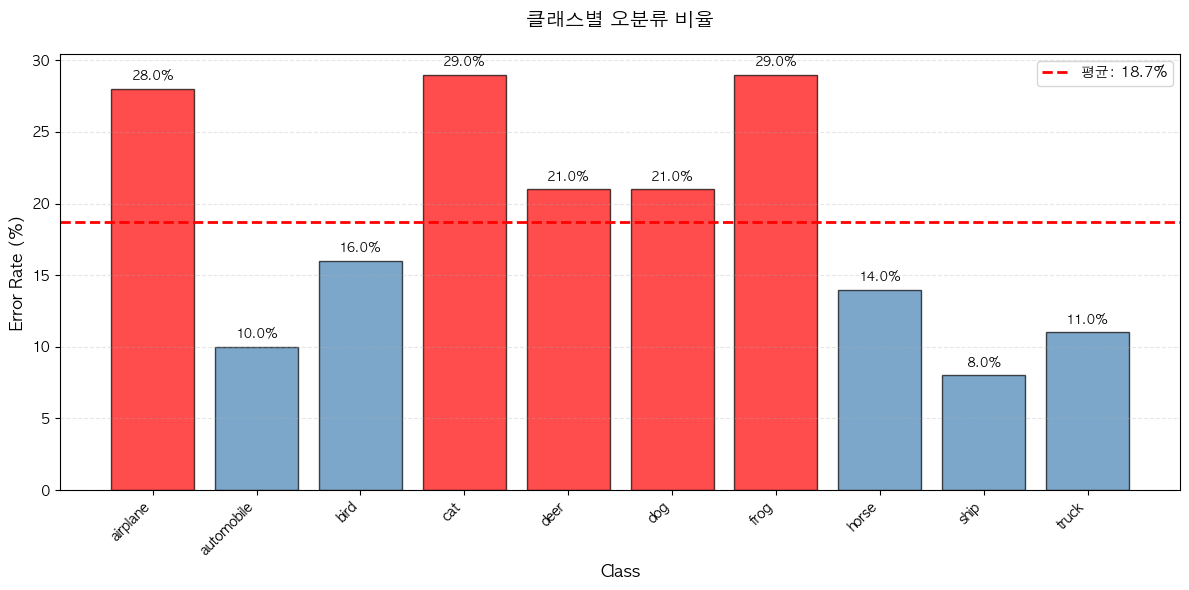

✅ 클래스별 오분류 비율 시각화 완료!

✅ 전체 평가 완료!

🎉 최종 테스트 정확도: 81.30%
🎉 최종 테스트 F1: 0.8124


In [11]:
# ============================================================
# 8. 평가 및 결과 분석
# ============================================================
import platform
import matplotlib.pyplot as plt

# 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

from src.evaluation import run_full_evaluation

# Config 기반으로 간단하게!
results = run_full_evaluation(
    fold_results=fold_results,
    test_dataset=test_dataset,
    class_names=class_names,
    config=config,
    device=device,
    use_wandb=config.USE_WANDB
)

print(f"\n🎉 최종 테스트 정확도: {results['test_acc']:.2f}%")
print(f"🎉 최종 테스트 F1: {results['test_f1']:.4f}")

In [12]:
# ============================================================
# 9. Wandb 종료
# ============================================================
if config.USE_WANDB:
    import wandb
    wandb.finish()
    print("\n✅ Wandb 종료")

print("\n🎉 실험 완료!")


🎉 실험 완료!


In [16]:
# ============================================================
# 10. 실험 결과 저장
# ============================================================
from src.logger import log_experiment_results

log_experiment_results(
    fold_results=fold_results,
    results=results,
    config=config
)

print("\n🎉 모든 작업 완료!")


✅ 실험 결과 저장: /Users/seoyeonmun/CV_competition_practice/CV_competition_practice/logs/experiment_20251030_172642.md

🎉 모든 작업 완료!
